In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/palm-all/Palm_Features.xlsx
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709808780105.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709795126494.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709809527125.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709619358067.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709638101111.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709703559788.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709884321143.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709886794732.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709790324469.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709977033943.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709969146179.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709711010517.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709887836179.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1709810564770.jpg
/kaggle/input/palm-all/Palm Masked/Palm Masked/1

In [2]:
import pandas as pd 
df = pd.read_excel('/kaggle/input/palm-all/Palm_Features.xlsx')
df = df[['Image_Name','Hb Value']]
df.head()

,Image_Name,Hb Value
0,1709617238375.jpg,11.5
1,1709617534838.jpg,11.6
2,1709618528581.jpg,11.1
3,1709619358067.jpg,12.1
4,1709619811692.jpg,12.2


In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.176, random_state=42)

In [4]:
print('train_df shape',train_df.shape)
print('test_df shape',test_df.shape)
print('tval_df shape',val_df.shape)

train_df shape (292, 2)
test_df shape (63, 2)
tval_df shape (63, 2)


In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

def load_image_and_label(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # ResNet50 expects 224x224
    # Scale pixel values [0, 1] or standardize them
    image = image / 255.0
    return image, label

def create_tf_dataset(df, images_folder, batch_size=8, shuffle=True):
    # Construct full paths to images
    image_paths = [os.path.join(images_folder, img) for img in df['Image_Name'].values]
    labels = df['Hb Value'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_ds = create_tf_dataset(train_df, "/kaggle/input/palm-all/Palm Masked/Palm Masked", batch_size=16, shuffle=True)
val_ds   = create_tf_dataset(val_df,   "/kaggle/input/palm-all/Palm Masked/Palm Masked", batch_size=16, shuffle=False)
test_ds  = create_tf_dataset(test_df,  "/kaggle/input/palm-all/Palm Masked/Palm Masked", batch_size=16, shuffle=False)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [12]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [13]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 55.8254 - mean_absolute_error: 6.2750 - val_loss: 113.4647 - val_mean_absolute_error: 10.5103
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 5.9429 - mean_absolute_error: 1.9779 - val_loss: 129.1131 - val_mean_absolute_error: 11.2303
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.8974 - mean_absolute_error: 1.3544 - val_loss: 132.0325 - val_mean_absolute_error: 11.3589
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 1.2628 - mean_absolute_error: 0.9189 - val_loss: 131.0635 - val_mean_absolute_error: 11.3156
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.8542 - mean_absolute_error: 0.7344 - val_loss: 127.1889 - val_mean_absolute_error: 11.1428
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.9223 - mean_absolute_error: 0.7470 - val_loss: 129.4706 - val_mean_absolute_error: 11.2449
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.6691 - mean_absolu

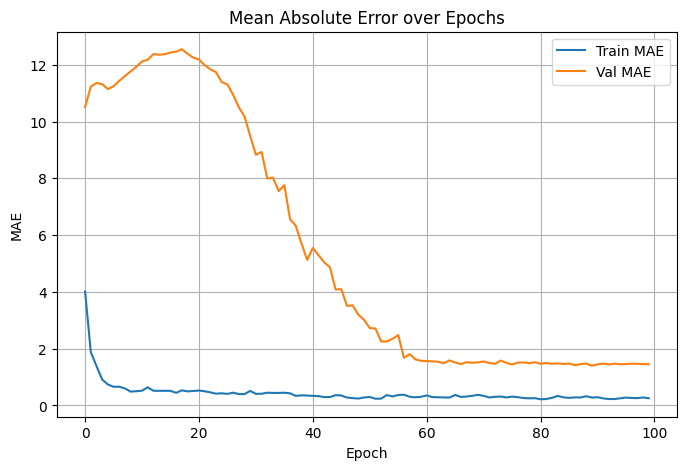

In [14]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.4670 - mean_absolute_error: 1.7622
Test MAE: 1.656899333000183


In [16]:
# Save your model in HDF5 format
model.save("resnet-50-trainable-true-palm.h5")

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [20]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [21]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 58.9927 - mean_absolute_error: 6.5886 - val_loss: 79.9364 - val_mean_absolute_error: 8.7717
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 7.8129 - mean_absolute_error: 2.1860 - val_loss: 70.5728 - val_mean_absolute_error: 8.2196
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 5.3572 - mean_absolute_error: 1.8526 - val_loss: 59.1470 - val_mean_absolute_error: 7.4907
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 3.9879 - mean_absolute_error: 1.5866 - val_loss: 44.6501 - val_mean_absolute_error: 6.4513
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 3.0801 - mean_absolute_error: 1.4346 - val_loss: 43.5817 - val_mean_absolute_error: 6.3713
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.9838 - mean_absolute_error: 1.3583 - val_loss: 37.8287 - val_mean_absolute_error: 5.9015
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 3.3551 - mean_absolute_error: 1

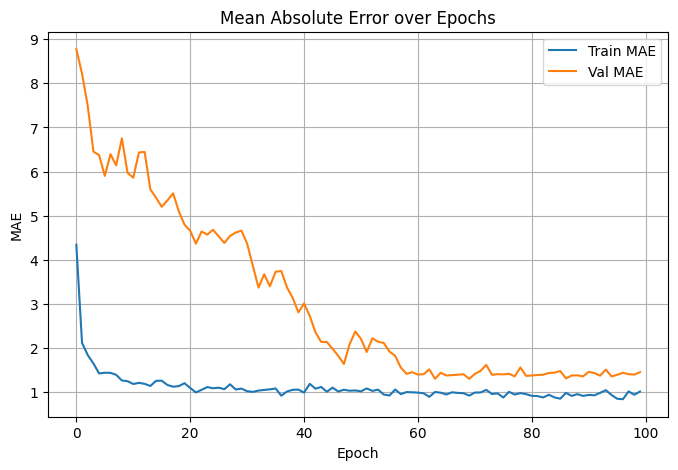

In [22]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.7042 - mean_absolute_error: 1.7791
Test MAE: 1.6978378295898438


In [24]:
# Save your model in HDF5 format
model.save("resnet-50-trainable-true_custom-palm.h5")